In [1]:
!pip install dicom2nifti nibabel nilearn scipy numpy matplotlib pandas tabulate

import functools
import dicom2nifti
import nibabel as nib
from nibabel.processing import resample_from_to
import nilearn as nil
from nilearn import plotting
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
import docker
import pickle
from multiprocessing import Pool
from nilearn import image

In [2]:
#dumb dice

neg_to_zero= lambda x: 0 if x < 0 else x
neg_to_zero = np.vectorize(neg_to_zero)

pos_to_zero= lambda x: 0 if x > 0 else x
pos_to_zero = np.vectorize(pos_to_zero)

pos_to_neg= lambda x: -1 if x > 0 else x
pos_to_neg = np.vectorize(pos_to_neg)


def np_intersect_slice(a,b)->np.array:
    assert(a.shape == b.shape)
    assert(len(a.shape)==2)
    return np.logical_and(a,b).astype(float)

def intersect_slice(a,b)->np.array:
    assert(a.shape == b.shape)
    assert(len(a.shape)==2)
    out = []
    for row in range(0,len(a)):
        intersection = []
        for col in range(0,len(a[row])):
            value = 0.0
            if a[row,col]>0 and b[row,col]>0:
                value =1.0
            if a[row,col]< -0 and b[row,col]< -0:
                value = -1.0
            intersection+=[value]
        out+=[intersection]

    return np.array(out)

def intersect_nifti(a,b,abs=True,keep_sign=True)-> nib.Nifti2Image:
    assert(a.shape==b.shape)
    adata = np.absolute(a.get_fdata()) if abs else a.get_fdata()
    bdata = np.absolute(b.get_fdata()) if abs else b.get_fdata()
    adata=np.nan_to_num(adata)
    bdata=np.nan_to_num(bdata)

    if abs:
        img = np.logical_and(adata,bdata).astype(float)
        img = nib.Nifti2Image(img,np.eye(4))
        return img
    else:
        if keep_sign:
            img = []
            for i in range(0,len(adata)):
                img+=[intersect_slice(adata[i],bdata[i])]
            img = np.array(img)
            img = nib.Nifti2Image(img,np.eye(4))
            return img
        
        else:
            aneg,bneg = pos_to_zero(adata),pos_to_zero(bdata)
            apos,bpos = neg_to_zero(adata),neg_to_zero(bdata)

            img_neg = np.logical_and(aneg,bneg).astype(float)
            img_neg = pos_to_neg(img_neg)
            img_pos = np.logical_and(apos,bpos).astype(float)

            img = nib.Nifti2Image(np.logical_or(img_neg,img_pos).astype(float),np.eye(4))

            return img

def cardinal(a:nib.Nifti2Image,pos=True,abs=True)->int:
    data = np.absolute(a.get_fdata()) if abs else a.get_fdata()
    data=np.nan_to_num(data)
    total_card = 0
    if pos:
        return np.count_nonzero(data)
        #for slice in data:
        #    for row in slice:
        #        total_card += sum(list(map(lambda x: 1 if x>0 else 0,row)))
    else:
        return np.count_nonzero(pos_to_zero(data))
        #for slice in data:
        #    for row in slice:
        #        total_card += sum(list(map(lambda x: 1 if x<0 else 0,row)))
    return total_card


#2 * |X ∩ Y| / (|X| + |Y|)
def dice(a,b,inter=None,pos=True,abs=True,keep_sign=True)->float:
    if inter is not None:
        return 2 * cardinal(inter,pos,abs)/(cardinal(a,pos,abs)+cardinal(b,pos,abs))
    else:  
        return 2 * cardinal(intersect_nifti(a,b,abs,keep_sign),pos,abs)/(cardinal(a,pos,abs)+cardinal(b,pos,abs))


In [3]:
#EMPENN DICE

import nibabel as nib
from nibabel.processing import resample_from_to
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import scipy
import os
import warnings

def pair_sorrenson_dice(pair):
    return sorrenson_dice(pair[0],pair[1])

def pair_cmp(pair):
    return raw_cmp(pair[0],pair[1])


#def pair_sorrenson_dice(pair):
#    data1_img = nib.load(pair[0])
#    data2_img = nib.load(pair[1])
#    data1_resl_img = resample_from_to(data1_img, data2_img, order=0)
#    data2_resl_img = resample_from_to(data2_img, data1_img, order=0)
#    return dice(data1_resl_img,data2_resl_img,pos=True,abs=True)


def raw_cmp(data1_file:str, data2_file:str, equal_strict=True):
    # Load nifti images
    try:
        data1_img = nib.load(data1_file)
        data2_img = nib.load(data2_file)

        # Load data from images
        data2 = data2_img.get_fdata()
        data1 = data1_img.get_fdata()

        data1 = np.nan_to_num(data1)
        data2 = np.nan_to_num(data2)
        
        data2 = np.absolute(data2)
        data1 = np.absolute(data1)

        if equal_strict:
            return np.array_equal(data1,data2)
        else:
            return np.allclose(data1,data2)
        

    except:
        return False

def sorrenson_dice(data1_file:str, data2_file:str, reslice=True):
    # Load nifti images
    data1_img = nib.load(data1_file)
    data2_img = nib.load(data2_file)

    # Load data from images
    data2 = data2_img.get_fdata()
    data1 = data1_img.get_fdata()

    # Get asbolute values (positive and negative blobs are of interest)
    data2 = np.absolute(data2)
    data1 = np.absolute(data1)

    if reslice:
        # Resample data1 on data2 using nearest nneighbours
        data1_resl_img = resample_from_to(data1_img, data2_img, order=0)
        # Load data from images
        data1_res = data1_resl_img.get_fdata()
        data1_res = np.absolute(data1_res)
            
        # Resample data2 on data1 using nearest nneighbours
        data2_resl_img = resample_from_to(data2_img, data1_img, order=0)        
        data2_res = data2_resl_img.get_fdata()
        data2_res = np.absolute(data2_res)

    # Masking (compute Dice using intersection of both masks)
    if reslice:
        background_1 = np.logical_or(np.isnan(data1), np.isnan(data2_res))
        background_2 = np.logical_or(np.isnan(data1_res), np.isnan(data2))

        data1 = np.nan_to_num(data1)
        data1_res = np.nan_to_num(data1_res)
        data2 = np.nan_to_num(data2)
        data2_res = np.nan_to_num(data2_res)

        num_activated_1 = np.sum(data1 > 0)
        num_activated_res_1 = np.sum(data1_res>0)
        num_activated_2 = np.sum(data2>0)
        num_activated_res_2 = np.sum(data2_res>0)

        dark_dice_1 = np.zeros(2)
        if num_activated_1 != 0:
            dark_dice_1[0] = np.sum(data1[background_1]>0).astype(float)/num_activated_1*100
        if num_activated_res_1 != 0:
            dark_dice_1[1] = np.sum(data1_res[background_2]>0).astype(float)/num_activated_res_1*100

        dark_dice_2 = np.zeros(2)
        if num_activated_2 != 0:
            dark_dice_2[0] = np.sum(data2[background_2]>0).astype(float)/num_activated_2*100
        if num_activated_res_2 != 0:
            dark_dice_2[1] = np.sum(data2_res[background_1]>0).astype(float)/num_activated_res_2*100

        data1[background_1] = 0
        data2_res[background_1] = 0

        data1_res[background_2] = 0
        data2[background_2] = 0
    else:
        background = np.logical_or(np.isnan(data1), np.isnan(data2))

        data1 = np.nan_to_num(data1)
        data2 = np.nan_to_num(data2)

        num_activated_1 = np.sum(data1 > 0)
        num_activated_2 = np.sum(data2>0)

        dark_dice = np.zeros(2)
        if num_activated_1 !=0:
            dark_dice[0] = np.sum(data1[background]>0).astype(float)/num_activated_1*100

        if num_activated_2 !=0:
            dark_dice[1] = np.sum(data2[background]>0).astype(float)/num_activated_2*100

        data1[background] = 0
        data2[background] = 0

    # Vectorize
    data1 = np.reshape(data1, -1)
    data2 = np.reshape(data2, -1)
    if reslice:
        data1_res = np.reshape(data1_res, -1)
        data2_res = np.reshape(data2_res, -1)

    if reslice:
        dice_res_1 = 1-scipy.spatial.distance.dice(data1_res>0, data2>0)
        dice_res_2 = 1-scipy.spatial.distance.dice(data1>0, data2_res>0)

        if not np.isclose(dice_res_1, dice_res_2, atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dices are not close")

        if not np.isclose(dark_dice_1[0], dark_dice_1[1], atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")

        if not np.isclose(dark_dice_2[0], dark_dice_2[1], atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dark dices 2 are not close")

        dices = (dice_res_1, dark_dice_1[1], dark_dice_2[1])
    else:
        dices = (1-scipy.spatial.distance.dice(data1>0, data2>0), dark_dice[0], dark_dice[1])
    
    return dices

**hypothesis outputs**

In [4]:
nb_subjects=100
_2T6S = {"1t":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "1":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "2t":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "2":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "3t":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "3":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "4t":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "4":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "5t":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "5":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii",
        "6t":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold1/spmT_0002_thr.nii",
        "6":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0002.nii",
        "7t":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "7":"/l2_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii",
        "8t":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold1/spmT_0002_thr.nii",
        "8":"/l2_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0002.nii",
        "9t":"/l2_analysis_groupComp_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "9":"/l2_analysis_groupComp_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii"
        }
_U26C = {"1t":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "1":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "2t":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "2":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "3t":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "3":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "4t":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/_threshold0/spmT_0001_thr.nii",
        "4":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0002/spmT_0001.nii",
        "5t":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold1/spmT_0002_thr.nii",
        "5":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0002.nii",
        "6t":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold1/spmT_0002_thr.nii",
        "6":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0002.nii",
        "7t":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "7":"/group_level_analysis_equalIndifference_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii",
        "8t":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "8":"/group_level_analysis_equalRange_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii",
        "9t":"/group_level_analysis_groupComp_nsub_"+str(nb_subjects)+"/_contrast_id_0003/_threshold0/spmT_0001_thr.nii",
        "9":"/group_level_analysis_groupComp_nsub_"+str(nb_subjects)+"/_contrast_id_0003/spmT_0001.nii"
        }

**Experiments path**

In [5]:
base_path = "/extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/"
xp_a = "NARPS-2T6S-reproduced_2010a_r6685_100_run2"
#xp_a = "NARPS-2T6S-reproduced_2010a_r7219_100_run2"
xp_b = "NARPS-2T6S-reproduced_r2023b_100_ARM_run1"

In [6]:
from nilearn import plotting
file_a = base_path+xp_a+_2T6S.get("3t")
brain_vol_data=nib.load(file_a)
brain_vol_data=brain_vol_data.get_fdata()
#brain_vol_data=np.nan_to_num(brain_vol_data)
brain_vol_data.shape

(97, 115, 81)

In [7]:
from nilearn import plotting
file_b = base_path+xp_b+_2T6S.get("3t")
brain_vol_data2=nib.load(file_b)
brain_vol_data2=brain_vol_data2.get_fdata()
#brain_vol_data2=np.nan_to_num(brain_vol_data2)
brain_vol_data2.shape

(97, 115, 81)

In [8]:
import matplotlib.pyplot as plt


def sagittal_slice(img_data,idx)->np.array:
    return img_data[idx,:,:]

def horizontal_slice(img_data,idx)->np.array:
    return img_data[:,idx,:]

def frontal_slice(img_data,idx)->np.array:
    return img_data[:,:,idx]


def compute_difference_slicewise(img1,img2)->pd.DataFrame:
    brain_vol_data=nib.load(img1)
    brain_vol_data2=nib.load(img2)

    brain_vol_data=brain_vol_data.get_fdata()
    brain_vol_data2=brain_vol_data2.get_fdata()
    sag=[]
    hor=[]
    frt=[]
	
    bigger_dim=max(brain_vol_data.shape)
    
    for i in range(0,bigger_dim):
        try:
            slc = sagittal_slice(brain_vol_data,i)-sagittal_slice(brain_vol_data2,i)
            #diff+=[slc]
            slc = np.nan_to_num(slc)
            sag+=[[slc.mean().item(),slc.std().item(),slc.max().item(),slc.min().item(),slc.shape[0]*slc.shape[1],np.count_nonzero(slc)]]
            #print(slc.mean())
        except:
            sag+=[[None,None,None,None,None,None]]
            
    for i in range(0,bigger_dim):
        try:
            slc = horizontal_slice(brain_vol_data,i)-horizontal_slice(brain_vol_data2,i)
            slc = np.nan_to_num(slc)
            hor+=[[slc.mean().item(),slc.std().item(),slc.max().item(),slc.min().item(),slc.shape[0]*slc.shape[1],np.count_nonzero(slc)]]
        except:
            hor+=[[None,None,None,None,None,None]]
		
        try:
            slc = frontal_slice(brain_vol_data,i)-frontal_slice(brain_vol_data2,i)
            slc = np.nan_to_num(slc)
            frt+=[[slc.mean().item(),slc.std().item(),slc.max().item(),slc.min().item(),slc.shape[0]*slc.shape[1],np.count_nonzero(slc)]]
        except:
            frt+=[[None,None,None,None,None,None]]
	
    output = []
    for i in range(0,bigger_dim):
        output+=[[sag[i][0],sag[i][1],sag[i][1],sag[i][3],sag[i][4],sag[i][5],hor[i][0],hor[i][1],hor[i][2],hor[i][3],hor[i][4],hor[i][5],frt[i][0],frt[i][1],frt[i][2],frt[i][3],frt[i][4],frt[i][5]]]
    return pd.DataFrame(output,columns=['sag_mean','sag_std','sag_max','sag_min','sag_nb_elements','sag_non_zero_elements','hor_mean','hor_std','hor_max','hor_min','hor_nb_elements','hor_non_zero_elements','frt_mean','frt_std','frt_max','frt_min','frt_nb_elements','frt_non_zero_elements'])

In [21]:

def compute_difference_statmaps(img1,img2,xp_a,xp_b,hyp):

    file_a='./imgs/'+xp_a+'_'+hyp+'.png'
    file_b='./imgs/'+xp_b+'_'+hyp+'.png'
    file_ab = './imgs/diff_'+xp_a+'-'+xp_b+'_'+hyp+'.png'
    prev = nib.load(img1)
    brain_vol_data=prev.get_fdata()

    brain_vol_data2=nib.load(img2)
    brain_vol_data2=brain_vol_data2.get_fdata()

    #plotting.plot_stat_map(file_a)
    #plotting.plot_stat_map(file_b)
    #plotting.plot_stat_map(nib.Nifti1Image(brain_vol_data-brain_vol_data2,prev.affine,prev.header))

    threshold_percentile_img = image.threshold_img(img1, threshold="97%", copy=False)

    plotting.plot_stat_map(
        threshold_percentile_img,
        output_file=file_a,
        display_mode="y",
        cut_coords=5,
        title="Threshold image with string percentile"
    )

    threshold_percentile_img = image.threshold_img(img2, threshold="97%", copy=False)

    plotting.plot_stat_map(
        threshold_percentile_img,
        output_file=file_b,
        display_mode="y",
        cut_coords=5,
        title="Threshold image with string percentile"
    )

    threshold_percentile_img = image.threshold_img(nib.Nifti1Image(brain_vol_data-brain_vol_data2,prev.affine,prev.header), threshold="97%", copy=False)

    plotting.plot_stat_map(
        threshold_percentile_img,
        output_file=file_ab,
        display_mode="y",
        cut_coords=5,
        title="Threshold image with string percentile"
    )

def compute_difference_images(img1,img2,xp_a,xp_b,hyp):

    file_a='./imgs/'+xp_a+'_'+hyp+'.png'
    file_b='./imgs/'+xp_b+'_'+hyp+'.png'
    file_ab = './imgs/mask_'+xp_a+'-'+xp_b+'_'+hyp+'.png'
    prev = nib.load(img1)
    brain_vol_data=prev.get_fdata()

    brain_vol_data2=nib.load(img2)
    brain_vol_data2=brain_vol_data2.get_fdata()

    imgs_diff = brain_vol_data-brain_vol_data2

    trigger_mask = np.vectorize(lambda x: 0.0 if x > 1.0 else 1.0)
    enhance_mask = np.vectorize(lambda x: 100.0 if x > 0 else x)
    boolean_mask = lambda x: False if x > 0 else True
    
    imgs_diff_mask = trigger_mask(imgs_diff)
    imgs_values_mask = enhance_mask(imgs_diff)
    masked_data = imgs_diff_mask*brain_vol_data
    enhanced_data = masked_data+imgs_values_mask

    threshold_percentile_img = image.threshold_img(nib.Nifti1Image(enhanced_data,prev.affine,prev.header), threshold="97%", copy=False)

    #threshold_percentile_img = nilearn.masking.apply_mask(prev, imgs_diff_mask, dtype='f', smoothing_fwhm=None, ensure_finite=True)
    #plotting.plot_img(threshold_percentile_img, output_file=file_ab)
    plotting.plot_stat_map(
        threshold_percentile_img,
        output_file=file_ab,
        display_mode="y",
        cmap="bwr",
        cut_coords=5,
        title="Threshold image with string percentile"
    )


In [23]:
def compute_difference(base_path,xp_a,xp_b,hyp_dic):
    results=[]
    for k in hyp_dic.keys():
        print(k)
        file_a = base_path+xp_a+hyp_dic.get(k)
        file_b = base_path+xp_b+hyp_dic.get(k)
        try:
            sd = raw_cmp(file_a,file_b,equal_strict=False)
            if not sd:
                print("structure difference detected")
                print("COMPUTING RAW STATS")
                stats=compute_difference_slicewise(file_a,file_b)
                stats.to_csv('./csv/stats_'+xp_a+'-'+xp_b+'_'+k+'.csv')
                print("COMPUTING STATS MAPS")
                compute_difference_statmaps(file_a,file_b,xp_a,xp_b,k)
                compute_difference_images(file_a,file_b,xp_a,xp_b,k)
                
            sd = sorrenson_dice(file_a,file_b)
            results+=[[k,sd[0],sd[1],sd[2]]]
        except Exception as error:
            results+=[[k,-1.0,-1.0,-1.0]]
            print(error)
            print("no dice for",file_a,file_b)
        dice = pd.DataFrame(results,columns=['hyp','dice','dark_dice1','dark_dice2'])
        dice.to_csv('./csv/dice_'+xp_a+'-'+xp_b+'_'+k+'.csv')


In [29]:
a="/extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2010a_r7219_100_run1/l2_analysis_equalRange_nsub_100/_contrast_id_0002/spmT_0001.nii"
b="/extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2020b_100_run1/l2_analysis_equalRange_nsub_100/_contrast_id_0002/spmT_0001.nii"

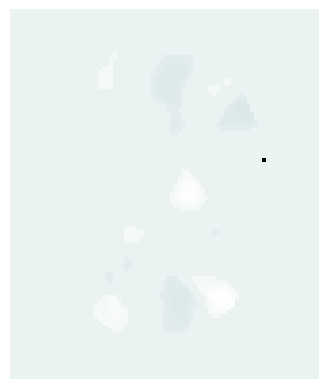

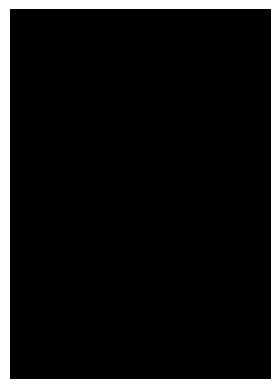

In [55]:
prev = nib.load(a)
brain_vol_data=prev.get_fdata()

brain_vol_data2=nib.load(b)
brain_vol_data2=brain_vol_data2.get_fdata()

imgs_diff = brain_vol_data-brain_vol_data2

trigger_mask = np.vectorize(lambda x: 0.0 if x > 1.0 else 1.0)
enhance_mask = np.vectorize(lambda x: -100.0 if x > 0 else x)
boolean_mask = lambda x: False if x > 0 else True

imgs_diff_mask = trigger_mask(imgs_diff)
imgs_values_mask = enhance_mask(imgs_diff)
masked_data = imgs_diff_mask*brain_vol_data
enhanced_data = masked_data+imgs_values_mask

threshold_percentile_img = image.threshold_img(nib.Nifti1Image(enhanced_data,prev.affine,prev.header), threshold="97%", copy=False)


plt.imshow(enhanced_data[:,50,:],cmap='bone')
plt.axis('off')
plt.show()
plt.imshow(enhanced_data[5,:,:],cmap='bone')
plt.axis('off')
plt.show()

#plotting.plot_img(
        #threshold_percentile_img,
        #output_file="meh.png",
        #display_mode="y",
        #cut_coords=5,
        #vmax=15.0,
        #radiological=True,
        #title="Threshold image with string percentile"
#)
#imgs_diff_mask

In [ ]:
import os
dirs= os.listdir("../narps_open_pipelines/run/reproduced")
versions = list(filter(lambda x: "2T6S" in x and (x.endswith("_100_run1") or "_ARM_" in x or "_DCI_run1" in x),dirs))
versions
versions_b = set(versions)
done=set()

for xp_a in versions:
    done=done.union({xp_a})
    #print(" DONE ---  ")
    #print(done)
    #print("  DOING XXX  ")
    for xp_b in versions_b.difference(done):
        #print(xp_b)
        compute_difference(base_path,xp_a,xp_b,_2T6S)
        

1t
1
2t
2
structure difference detected
3t
3
4t
4
structure difference detected
5t
5
6t
6
7t
7
8t
8
9t
9
structure difference detected
1t
1
2t
2
3t
3
4t
4
5t
5
6t
6
7t
7
8t
8
9t
9
1t
structure difference detected
No such file or no access: '/extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2010a_r6225_100_run1/l2_analysis_equalIndifference_nsub_100/_contrast_id_0002/_threshold0/spmT_0001_thr.nii'
no dice for /extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2010a_r7219_100_run1/l2_analysis_equalIndifference_nsub_100/_contrast_id_0002/_threshold0/spmT_0001_thr.nii /extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2010a_r6225_100_run1/l2_analysis_equalIndifference_nsub_100/_contrast_id_0002/_threshold0/spmT_0001_thr.nii
1
structure difference detected
No such file or no access: '/extsd/RIPOST/NARPS/narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_2010a_r6225_100_run1/l2_analysis_equalIndifference